In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow import keras

In [6]:
data, target = dr.read_data(window=22)
data.info()
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2406 non-null   object 
 1   Daily_trading_range  2406 non-null   float64
 2   Log_Volume_change    2406 non-null   float64
 3   Daily_return         2406 non-null   float64
 4   Daily_log_return     2406 non-null   float64
 5   Index                2406 non-null   float64
 6   oil                  2406 non-null   float64
dtypes: float64(6), object(1)
memory usage: 131.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2384 entries, 0 to 2383
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2384 non-null   float64
dtypes: float64(1)
memory usage: 37.2 KB


In [7]:
data = data.drop(['Daily_return','Date'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2406 non-null   float64
 1   Log_Volume_change    2406 non-null   float64
 2   Daily_log_return     2406 non-null   float64
 3   Index                2406 non-null   float64
 4   oil                  2406 non-null   float64
dtypes: float64(5)
memory usage: 94.1 KB


In [10]:
x_values = data.iloc[:len(data)-22]
y_values = target

In [11]:
x_values.info()
y_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2384 entries, 0 to 2383
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2384 non-null   float64
 1   Log_Volume_change    2384 non-null   float64
 2   Daily_log_return     2384 non-null   float64
 3   Index                2384 non-null   float64
 4   oil                  2384 non-null   float64
dtypes: float64(5)
memory usage: 93.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2384 entries, 0 to 2383
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2384 non-null   float64
dtypes: float64(1)
memory usage: 37.2 KB


In [12]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_values)
scaled_y = scaler.fit_transform(y_values)

In [13]:
split = int(len(x_values)*0.8)

In [14]:
window = 22
trainX = np.array(scaled_x[:split])
testX = np.array(scaled_x[split:])
trainY = np.array(scaled_y[:split])
testY = np.array(scaled_y[split:])

trainX.shape

(1907, 5)

In [15]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
for i in range(window, len(testX)):
    Xtest.append(testX[i-window:i, :testX.shape[1]])
    ytest.append(testY[i])

In [16]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [17]:
print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1885, 22, 5)
(1885, 1)
-----
(455, 22, 5)
(455, 1)


In [19]:
def create_model(neurons1=10, neurons2=10, neurons3=10, lr=0.001, activation='tanh'):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dense(neurons1,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons2,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons3,activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    adam = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model
    # model.fit(Xtrain, ytrain, epochs=150, batch_size=16, validation_split=0.1, shuffle=False)

In [20]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


In [21]:
regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

In [22]:
tscv = TimeSeriesSplit(n_splits=3)


In [23]:
params = dict(neurons1=[64,32,16,10,5],
              neurons2=[64,32,16,10,5],
              neurons3=[64,32,16,10,5],
              batch_size=[32,16],
              lr=[0.001,0.005,0.0005],
              activation=['tanh','relu'],
              epochs=[50,100]
              )
grid = GridSearchCV(estimator=regressor, param_grid=params, verbose=10, cv=tscv)
grid_result = grid.fit(Xtrain, ytrain)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits
[CV 1/3; 1/1500] START activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 1/3; 1/1500] END activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   1.9s
[CV 2/3; 1/1500] START activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 2/3; 1/1500] END activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.5s
[CV 3/3; 1/1500] START activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 3/3; 1/1500] END activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   3.1s
[CV 1/3; 2/1500] START activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=32
[CV 1/3; 2/1500] END activation=tanh, batch_size=32, lr=0.001, neurons1=64, neurons2=64, neurons3=32; total time=   1.9s
[CV 2/3; 2/1500] START activation=tanh,

KeyboardInterrupt: 

In [128]:
print('Best score s: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
bestParams = grid_result.best_params_

Best score s: -0.0013819751446135342 using {'dropout1': 0.3, 'dropout2': 0.1, 'dropout3': 0.5}


In [19]:
model = create_model(dropout1=0.3,dropout2=0.1,dropout3=0.5)
model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)
forecast = model.predict(Xtest)

Epoch 1/50
114/114 [==============================] - 1s 2ms/step - loss: 0.4753
Epoch 2/50
114/114 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 3/50
114/114 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 4/50
114/114 [==============================

In [20]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

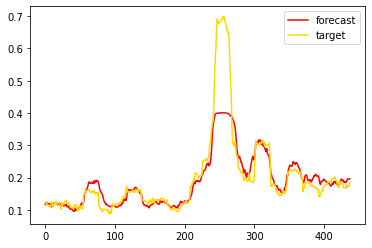

In [21]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [22]:
testScore = mean_squared_error(rev_ytest, rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(rev_ytest, rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.004088834838339996 MSE
test Score: 0.0639439976724946 RMSE
test Score: 0.116710224804941 MAPE


In [ ]:
model.save